In [177]:
# Thoughts EDA for edits:
# - top words for additions
# - top words for deletions 
# - how many times a contributor is added? (Authorship model)
# - how many times a correction is issued
# - how many times a headline is updated
# - how many refuters occur
# - discourse tags of additions/edits/deletions
# - how often are DATES, people, other NEs added?
# - When are sentences removed:
#     hypotheses:
#     --------------------------------------------------------------
#         "it's not immediately clear"
#         "no information"
#         "trying to determine"
#         "yet to establish"
#         "no official word"
#         "still being compiled"
#         "more details soon"
#         "not yet known"
#         "cause not determined"
#         "check back for updates"

In [35]:
import pandas as pd 
import glob
import ast
import pickle
import numpy as np 
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.rc('font', size=14)

In [36]:
with open('hits_cache/2021-10-24__all-answers.pkl', 'rb') as f:
    all_answers = pickle.load(f)    

In [54]:
doc_ids = list(map(lambda x: x['doc_id'], all_answers))
doc_ids = list(map(ast.literal_eval, doc_ids))
doc_ids = list(set(doc_ids))
doc_ids = sorted(doc_ids, key=lambda x: x[0])

In [59]:
annotated_doc_ids = pd.DataFrame(doc_ids, columns=['source', 'entry_id', 'version_x', 'version_y'])

In [693]:
all_prec_recall = []

for max_distance in tqdm(np.arange(0, .45, .01)):
    all_comparisons = []
    for a in all_answers:
        pred_arcs = (
            pd.DataFrame(a['original_arcs'])
             .dropna()
             .loc[lambda df: df[['avg_sentence_distance_x', 'avg_sentence_distance_y']].min(axis=1) < max_distance]
             [['sent_idx_x', 'sent_idx_y']].astype(int)
        )

        annotated_arcs = pd.DataFrame(a['annotated connections'], columns=['sent_idx_x', 'sent_idx_y']).astype(int)

        comparison = (pred_arcs.assign(in_pred=True)
         .merge(
             annotated_arcs.assign(in_annot=True),
             how='outer',
             left_on=['sent_idx_x', 'sent_idx_y'],
             right_on=['sent_idx_x', 'sent_idx_y'],
           )
         .fillna(False)
        )

        all_comparisons.append(comparison)

    all_comparison_df = pd.concat(all_comparisons)
    prec_recall = all_comparison_df[['in_pred', 'in_annot']].mean().rename({'in_pred': 'recall', 'in_annot': 'precision'})
    prec_recall_df = prec_recall.to_frame('metrics').assign(cutoff=max_distance)
    all_prec_recall.append(prec_recall_df)

  0%|          | 0/45 [00:00<?, ?it/s]

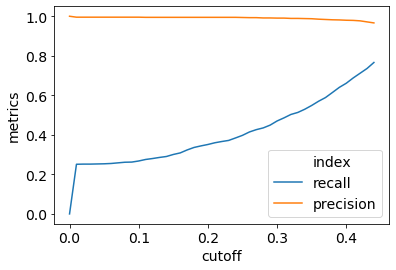

In [696]:
all_prec_recall_df = pd.concat(all_prec_recall).reset_index()
sns.lineplot(data=all_prec_recall_df, y='metrics', x='cutoff', hue='index')

In [718]:
(all_prec_recall_df
 .pivot(index='cutoff', columns='index', values='metrics')
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
)

cutoff
0.00    0.000000
0.01    0.401132
0.02    0.402138
0.03    0.402138
0.04    0.403144
0.05    0.404148
0.06    0.406152
0.07    0.410145
0.08    0.414119
0.09    0.415109
0.10    0.422005
0.11    0.431413
0.12    0.437200
0.13    0.443896
0.14    0.449591
0.15    0.461786
0.16    0.471035
0.17    0.488305
0.18    0.502546
0.19    0.511310
0.20    0.519110
0.21    0.528532
0.22    0.535309
0.23    0.541188
0.24    0.554447
0.25    0.567823
0.26    0.584848
0.27    0.596517
0.28    0.604759
0.29    0.618305
0.30    0.637630
0.31    0.651938
0.32    0.666971
0.33    0.675876
0.34    0.689466
0.35    0.705329
0.36    0.722142
0.37    0.736484
0.38    0.755736
0.39    0.774866
0.40    0.789398
0.41    0.807863
0.42    0.823371
0.43    0.837204
0.44    0.854618
dtype: float64

# Recreate sentence matching

In [642]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np 
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from scipy.optimize import linear_sum_assignment

In [247]:
model = AutoModel.from_pretrained('prajjwal1/bert-mini')
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-mini')

In [472]:
import numpy_indexed as npi
def avg_across_subwords(tok_vec, b, cut_cls_char=True):
    word_ids = b.word_ids()
    word_ids = list(map(lambda x: -1 if x is None else x, word_ids))
    tok_vec = tok_vec[:len(word_ids)].detach().cpu().numpy()
    index, tok_vec = npi.group_by(np.array(word_ids)).mean(tok_vec)
    if cut_cls_char:
        return index[1:], tok_vec[1:]
    else:
        return index, tok_vec

In [784]:
def get_all_comparisons(all_answers, sent_comp_metric, metric_dir='min', *args, **kwargs):
    all_comparisons = []
    for a in tqdm(all_answers):
        nodes_df = pd.DataFrame(a['nodes'])
        sentence_pair_df = sent_comp_metric(nodes_df=nodes_df, *args, **kwargs)
        annotated_arcs = pd.DataFrame(
            a['annotated connections'], 
            columns=['sent_idx_x', 'sent_idx_y']
        ).astype(int)

        for cutoff in np.arange(0, 1, .02):
            if metric_dir == 'min':
                pred_arcs = (
                    sentence_pair_df
                     .loc[lambda df: df[['avg_sentence_sim_x', 'avg_sentence_sim_y']].max(axis=1) > cutoff]
                     [['sent_idx_x', 'sent_idx_y']].astype(int)
                )
            else:
                pred_arcs = (
                    sentence_pair_df
                     .loc[lambda df: df[['avg_sentence_distance_x', 'avg_sentence_distance_y']].min(axis=1) < cutoff]
                     [['sent_idx_x', 'sent_idx_y']].astype(int)
                )

            comparison = (pred_arcs.assign(in_pred=True)
             .merge(
                 annotated_arcs.assign(in_annot=True),
                 how='outer',
                 left_on=['sent_idx_x', 'sent_idx_y'],
                 right_on=['sent_idx_x', 'sent_idx_y'],
               )
             .fillna(False)
            )

            all_comparisons.append(
                comparison[['in_pred', 'in_annot']].assign(cutoff=cutoff)
            )
    return pd.concat(all_comparisons)

In [742]:
def tensorize_df_bert(nodes_df):
    ## prepare data input
    nodes_df['sentence_tokens'] = nodes_df['sentence'].apply(tokenizer)
    nodes_df['sentence_tensors'] = nodes_df['sentence_tokens'].apply(lambda x: torch.tensor(x.input_ids))
    nodes_df['sentence_lens'] = nodes_df['sentence_tensors'].str.len()
    nodes_df['max_len'] = nodes_df['sentence_lens'].max()
    nodes_df['padding'] = nodes_df['max_len'] - nodes_df['sentence_lens']
    nodes_df['attention_mask'] = (
        nodes_df
          .apply(lambda x: [1] * x['sentence_lens'] + [0] * x['padding'] , axis=1)
          .apply(torch.tensor)
    )
    token_input = pad_sequence(
        nodes_df['sentence_tensors'].tolist(),
        batch_first=True
    )
    attention_mask = torch.vstack(nodes_df['attention_mask'].tolist())
    return token_input, attention_mask, nodes_df

In [721]:
def get_sentence_similarities_unigram_bert_1(nodes_df):
    token_input, attention_mask, nodes_df = tensorize_df_bert(nodes_df)

    ## Get output
    output = model(token_input, attention_mask=attention_mask)

    ## split words into X and Y
    word_df = []
    for idx, version, s_idx, tokens in nodes_df[['version', 'sent_idx', 'sentence_tokens']].itertuples():
        sentence_vec = output.last_hidden_state[idx]
        word_ids, avg_vecs = avg_across_subwords(sentence_vec, tokens)
        for word_idx in word_ids:
            word_df.append({
                'version': version,
                's_idx': s_idx,
                'w_idx': word_idx,
                'tensor': avg_vecs[word_idx]
            })
    
    word_df = pd.DataFrame(word_df)
    words_x = word_df.loc[lambda df: df['version'] == df['version'].min()]
    words_y = word_df.loc[lambda df: df['version'] == df['version'].max()]

    ## perform comparisons
    sentence_pairs = []
    for s_idx_x in words_x['s_idx'].drop_duplicates():
        for s_idx_y in words_y['s_idx'].drop_duplicates():
            t_y = np.vstack(words_y.loc[lambda df: df['s_idx'] == s_idx_y]['tensor'].tolist())
            t_x = np.vstack(words_x.loc[lambda df: df['s_idx'] == s_idx_x]['tensor'].tolist())
            # 
            x_y_sim = cosine_similarity(t_x, t_y)
            row_ind, col_ind = linear_sum_assignment(1 - x_y_sim)
            opt_sims = x_y_sim[row_ind, col_ind].sum()
            x_sim = opt_sims / len(t_x)
            y_sim = opt_sims / len(t_y)
            sentence_pairs.append({
                'avg_sentence_sim_x': x_sim,
                'avg_sentence_sim_y': y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [792]:
all_comparison_df = get_all_comparisons(all_answers, get_sentence_similarities_unigram_bert_1)

  0%|          | 0/193 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

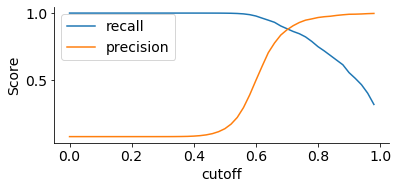

In [795]:
prec_recall = (all_comparison_df
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [796]:
#                   prec * recall
# f1-score = 2 * -----------------
#                   prec + recall

(prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8851764394323925

# Regular Sequences

In [728]:
from difflib import SequenceMatcher

In [749]:
def get_sent_char_sim_method_1(nodes_df):
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'sentence']].drop_duplicates().itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'sentence']].drop_duplicates().itertuples(index=False):
            x_y_sim = SequenceMatcher(None, sent_x, sent_y).ratio()
            sentence_pairs.append({
                'avg_sentence_sim_x': x_y_sim,
                'avg_sentence_sim_y': x_y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [741]:
sent_diff_1_comparisons = get_all_comparisons(all_answers, get_sent_char_sim_method_1)

  0%|          | 0/193 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

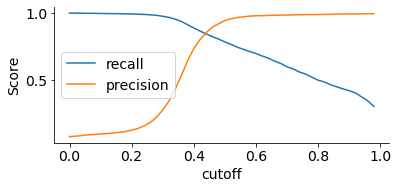

In [745]:
sent_diff_1_prec_recall = (sent_diff_1_comparisons
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = sent_diff_1_prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [748]:
(sent_diff_1_prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8586017403337957

In [752]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [756]:
def get_sent_char_sim_method_2(nodes_df):
    sentences = nodes_df['sentence'].tolist()
    tokenized = []
    for doc in nlp.pipe(sentences, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        tokens = list(map(lambda x: x.text, doc))
        tokenized.append(tokens)
    nodes_df['tokenized_sentences'] = tokenized
    
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
            x_y_sim = SequenceMatcher(None, sent_x, sent_y).ratio()
            sentence_pairs.append({
                'avg_sentence_sim_x': x_y_sim,
                'avg_sentence_sim_y': x_y_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [758]:
sent_diff_2_comparisons = get_all_comparisons(all_answers, get_sent_char_sim_method_2)

  0%|          | 0/193 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

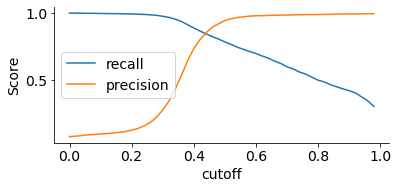

In [760]:
sent_diff_2_prec_recall = (sent_diff_2_comparisons
 .groupby('cutoff')
 .mean()
 .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
)
ax = sent_diff_1_prec_recall.plot(figsize=(6, 2.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Score')

In [791]:
(sent_diff_2_prec_recall
 .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
 .max()
)

0.8981197727501872

In [764]:
from nltk.translate import bleu_score

In [785]:
def get_bleu_comp(nodes_df, weights, *args, **kwargs):
    sentences = nodes_df['sentence'].tolist()
    tokenized = []
    for doc in nlp.pipe(sentences, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        tokens = list(map(lambda x: x.text, doc))
        tokenized.append(tokens)
    nodes_df['tokenized_sentences'] = tokenized
    
    ## perform comparisons
    sentence_pairs = []
    sents_x = nodes_df.loc[lambda df: df['version'] == df['version'].min()]
    sents_y = nodes_df.loc[lambda df: df['version'] == df['version'].max()]

    sentence_pairs = []
    for s_idx_x, sent_x in sents_x[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
        for s_idx_y, sent_y in sents_y[['sent_idx', 'tokenized_sentences']].itertuples(index=False):
            x_sim = bleu_score.sentence_bleu([sent_x], sent_y, weights=weights)
            y_sim = bleu_score.sentence_bleu([sent_y], sent_x, weights=weights)
            sentence_pairs.append({
                'avg_sentence_sim_x': x_sim,
                'avg_sentence_sim_y': x_sim,
                'sent_idx_x': s_idx_x,
                'sent_idx_y': s_idx_y
            })

    sentence_pair_df = pd.DataFrame(sentence_pairs)
    return sentence_pair_df

In [786]:
bleu_unigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[1, 0, 0, 0])

  0%|          | 0/193 [00:00<?, ?it/s]

In [787]:
bleu_bigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[0, 1, 0, 0])
bleu_trigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[0, 0, 1, 0])
bleu_mixed_bigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[.5, .5, 0, 0])
bleu_mixed_trigram_comparisons = get_all_comparisons(all_answers, get_bleu_comp, weights=[.33, .33, .34, 0])

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

In [790]:
for b, k in [
    (bleu_unigram_comparisons, 'bleu unigram'),
    (bleu_bigram_comparisons, 'bleu bigram'),
    (bleu_trigram_comparisons, 'bleu trigram'),
    (bleu_mixed_bigram_comparisons, 'bleu mixed bigram'),
    (bleu_mixed_trigram_comparisons, 'bleu mixed trigram')
]:
    print(k)
    print(
        b
         .groupby('cutoff')
         .mean()
         .rename(columns={'in_pred': 'recall', 'in_annot': 'precision'})
         .apply(lambda x: 2 * (x['precision'] * x['recall']) / ((x['precision'] + x['recall'])),  axis=1)
         .max()
    )

bleu unigram
0.8673226661124263
bleu bigram
0.8918958525817935
bleu trigram
0.8880751825839377
bleu mixed bigram
0.8883862343439911
bleu mixed trigram
0.8913345439721306


In [ ]:
bleu_bigram_comparisons

# Subsequences